<a href="https://colab.research.google.com/github/willmelville/game_theory_sequencing/blob/main/simpler_sequence_rnn_testing_v2_final_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pybaseball

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 415 kB 6.4 MB/s 
     |████████████████████████████████| 297 kB 65.2 MB/s 
     |████████████████████████████████| 856 kB 41.7 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
import torch
import torch.nn as nn 
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pybaseball
from torch.nn.functional import log_softmax, pad
import copy
import gc
import torch.optim as optim
from tqdm import tqdm
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Data**

In [ ]:
#function to clean and organize data from statcast 
def organize_data(df):

    df = df.loc[df.balls < 4]
    df = df.loc[df.strikes < 3]

    df.dropna(subset = ['release_extension', 
                      'release_speed','release_spin_rate', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z'], axis = 0,
            inplace = True)

    #convert movement to inches instead of feet 
    df[['mx', 'mz']] = df[['pfx_x', 'pfx_z']].values * 12

    #one hot encode handedness
    pit_hand = pd.get_dummies(df['p_throws'], drop_first = False)
    bat_hand = pd.get_dummies(df['stand'], drop_first = False)
    df['pit_handR'] = pit_hand['R']
    df['bat_handR'] = bat_hand['R']
    df = df.drop(['p_throws', 'stand', 'pfx_x', 'pfx_z'], axis = 1)
    
    #remove bunts 
    df = df.loc[df.description.isin(['foul_bunt', 'bunt_foul_tip', 'missed_bunt']) == False]
    df = df.loc[df.events != 'sac_bunt']

    #define the pitch outcome 
    df['outcome'] = -1
    df.loc[df.type == 'B', 'outcome'] = 0 #called ball 
    df.loc[df.description == 'called_strike', 'outcome'] = 1 #called strike 
    df.loc[df.description.isin(['swinging_strike', 'swinging_strike_blocked']), 'outcome'] = 2 #swm 
    df.loc[df.description.isin(['foul', 'foul_tip']), 'outcome'] = 3 #foul ball 

    #the other outcomes are all batted balls, which should either be outs or singles, doubles, triples, or home runs 
    df.loc[(df.type == 'X') & (df.events.isin(['field_out', 'force_out', 'field_error', 'grounded_into_double_play', 'sac_fly', 'fielders_choice', 
                                               'fielders_choice_out', 'double_play', 'other_out', 'triple_play', 
                                               'sac_fly_double_play'])), 'outcome'] = 4 # in play out 
    df.loc[(df.type == 'X') & (df.events == 'single'), 'outcome'] = 5 #single 
    df.loc[(df.type == 'X') & (df.events == 'double'), 'outcome'] = 6 # double 
    df.loc[(df.type == 'X') & (df.events == 'triple'), 'outcome'] = 7 #triple 
    df.loc[(df.type == 'X') & (df.events == 'home_run'), 'outcome'] = 8 #hr 

    #if outcome is still -1, drop it 
    df = df.loc[df.outcome != -1]

    #define an is_swing column 
    df['is_swing'] = -1 
    df.loc[df.description.isin(['hit_into_play', 'foul', 'swinging_strike', 'swinging_strike_blocked', 'foul_tip']), 'is_swing'] = 1
    df.loc[df.description.isin(['called_strike', 'ball', 'blocked_ball', 'hit_by_pitch', 'pitchout']), 'is_swing'] = 0

    #define an is_miss column 
    df['is_miss'] = -1 
    df.loc[df.is_swing == 0 , 'is_miss'] = 0
    df.loc[df.description.isin(['swinging_strike', 'swinging_strike_blocked']), 'is_miss'] = 1 
    df.loc[df.description.isin(['hit_into_play', 'foul', 'foul_tip']), 'is_miss'] = 0
    return df

In [ ]:
#columns needed from statcast 
needed_columns = ['game_date', 'game_year', 'game_pk', 'player_name', 'pitcher', 'batter', 'pitch_type', 'pitch_name', 'stand', 'p_throws', 'balls', 'strikes', 'release_speed', 
                  'release_spin_rate', 'release_extension', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
                  'plate_x', 'plate_z',  'type', 'events', 'description', 'woba_value', 'at_bat_number', 'pitch_number']

In [ ]:
from google.colab import drive
drive.mount('/drive')

#read in the data
raw22 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_project/raw22.csv')
raw21 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_project/raw21.csv')
raw19 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_project/raw18_19_20.csv')
raw21 = raw21[needed_columns]
raw22 = raw22[needed_columns]
raw19 = raw19[needed_columns]

Mounted at /drive


In [ ]:
#clean the data

df21 = organize_data(raw21)
df22 = organize_data(raw22)
df19 = organize_data(raw19)

all_data = df22.append(df21, ignore_index = True)
#all_data = all_data.append(df19, ignore_index = True)

In [ ]:
#min max scale variables 
standardizer = StandardScaler().fit(all_data[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_extension', 'release_spin_rate', 
     'release_pos_x', 'release_pos_z']].values)

all_data[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_extension', 'release_spin_rate', 
     'release_pos_x', 'release_pos_z']] = standardizer.transform(all_data[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_extension', 'release_spin_rate', 
     'release_pos_x', 'release_pos_z']].values)

In [ ]:
df19[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_extension', 'release_spin_rate', 
     'release_pos_x', 'release_pos_z']] = standardizer.transform(df19[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_extension', 'release_spin_rate', 
     'release_pos_x', 'release_pos_z']].values)

In [ ]:
#get the batter index
batter_indices = pd.DataFrame({'batter': all_data.batter.unique()})

batter_indices['batter_index'] = batter_indices.index.values

#merge 
all_data = all_data.merge(batter_indices, on = 'batter')

In [ ]:
df19 = df19.merge(batter_indices, how = 'inner', on = 'batter')

In [ ]:
bi = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_project/batter_indices_final_model.csv')

**My Data Loader Code**

In [ ]:
train = all_data.copy()
#train = df19.copy()

In [ ]:
batch_size = 256

#define a dataloader type thing. Basically we break down at bats by pitch sequence length. 
#then for each length we need to break down all the plate appearances of that length into batches.
pa_lengths = train.groupby(['game_pk', 'at_bat_number'], as_index = False).agg(seq_length = ('pitch_number', 'max'),
                                                                               pitches_recorded = ('pitch_number', 'count'))
#merge with train
train = train.merge(pa_lengths, how = 'inner', on = ['game_pk', 'at_bat_number'])
#make sure the pitches recorded matches the sequence length
train = train.loc[train.seq_length == train.pitches_recorded]

train['pa_id'] = [str(train.game_pk.values[i]) + '-' + str(train.at_bat_number.values[i]) for i in range(train.shape[0])]
#train is ordered from latest to earliest, but I think we want our sequence to go from earliest up top to latest on bottom 
train = train[::-1]

features = ['balls', 'strikes', 'release_speed', 'release_spin_rate', 'plate_x', 'plate_z',
                'mx', 'mz', 'pit_handR', 'bat_handR', 'batter_index']

loader_list = []
for l in pa_lengths.seq_length.unique():
  d = train.loc[train.seq_length == l]
  pas = list(d.pa_id.unique())
  #for each batch, I need to continue to add plate appearances until I hit my batch size 
  while len(pas) > 0:
    pas_for_batch = []
    s = 0 
    while s < batch_size:
      if len(pas) != 0:
        pas_for_batch.append(pas.pop(0))
        s += l
      else:
        s+=1

    #get the pas for this batch 
    batch_data = d.loc[d.pa_id.isin(pas_for_batch)]
    pa_id_and_pitch_num = batch_data[['pa_id', 'pitch_number']].values
    batch_x = batch_data[features].values
    batch_y = batch_data.outcome.values.astype(int)
    #reshape so that each pa is a separate entry in the batch
    batch_x = batch_x.reshape((len(pas_for_batch), l, len(features)))
    batch_y = batch_y.reshape((len(pas_for_batch),l))
    torch_batch_x = torch.tensor(batch_x, dtype = torch.float)
    torch_batch_y = torch.tensor(batch_y, dtype = torch.long)
    
    #append to list 
    loader_list.append((pa_id_and_pitch_num, torch_batch_x, torch_batch_y))


#shuffle the batches so that the RNN is trained on variable length sequences right from the get go 
#this will also give you a train test split 
import random
random.seed(51)
random.shuffle(loader_list)
train_loader_list = loader_list[:3*len(loader_list)//4]
test_loader_list = loader_list[3*len(loader_list)//4:]

**RNN**

In [ ]:
#helper classes 

batter_embedding_dim = 13
output_embedding_dim = 13

class InputEmbedding(nn.Module):
  def __init__(self, hidden_size = 32, output_size = 9):
    super(InputEmbedding, self).__init__()
    self.hidden_size = hidden_size 
    self.output_size = output_size
    #define batter embedding 
    self.batter_embedding = nn.Embedding(batter_indices.shape[0], embedding_dim = batter_embedding_dim)

    #define embedding for the pitch concatenated with the batter embedding concatenated with hidden state 
    self.ie1 = nn.Linear(in_features = len(features) - 1 + batter_embedding_dim + self.hidden_size, out_features = 512)
    self.ie2 = nn.Linear(512, 256)
    self.ie3 = nn.Linear(256, 128)
    self.ie4 = nn.Linear(128, 64)
    self.ie5 = nn.Linear(64, self.output_size)
    self.relu = nn.ReLU()
    
  def forward(self, x, hidden):
    #batter index is last column of x 
    batter_idx = x[:,-1].int()
    bat_emb = self.batter_embedding(batter_idx)

    #concatenate batter embedding and input and hidden state
    conc = torch.concat((x[:,:-1], bat_emb, hidden), dim = 1)
    
    #run through layers 
    conc = self.relu(self.ie1(conc))
    conc = self.relu(self.ie2(conc))
    conc = self.relu(self.ie3(conc))
    conc = self.relu(self.ie4(conc))
    return self.ie5(conc)


class HiddenStateUpdater(nn.Module):

    def __init__(self, hidden_size = 32, output_size = 9):
        super(HiddenStateUpdater, self).__init__()
        self.hidden_size = hidden_size 
        self.output_size = output_size
        #we need a target embedding 
        self.target_embedding = nn.Embedding(self.output_size, output_embedding_dim)
        #remember, we are going to take our pitch and our output embedding and concatenate them together for the hidden state, so we need features 
        #plus output embedding dim minus 1 for the batter index which we don't want to include.
        self.l1 = nn.Linear(len(features) - 1 + output_embedding_dim, 256)
        self.l2 = nn.Linear(256, 128)
        self.l3 = nn.Linear(128, 64)
        self.l4 = nn.Linear(64,32)
        self.proj = nn.Linear(32, self.hidden_size)
        self.relu = nn.ReLU()

    def forward(self, x, y):
        #get the output embedding 
        y = self.target_embedding(y)
        #concatenate onto x 
        x = torch.concat((x, y), dim = -1)
        #feed through network
        x = self.relu(self.l1(x))
        x = self.relu(self.l2(x)) 
        x = self.relu(self.l3(x))
        x = self.relu(self.l4(x))
        return self.proj(x)

In [ ]:
class RNN(nn.Module):
  def __init__(self, hidden_size = 32, output_size = 9):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size 
    self.output_size = output_size 

    self.input_embedding = InputEmbedding(self.hidden_size, self.output_size)
    self.h_update = HiddenStateUpdater(self.hidden_size, self.output_size)
    self.relu = nn.ReLU()

    #initialize batter embeddings 
    self.input_embedding.batter_embedding.weight.data.fill_(1.)

  def forward(self, x, hidden, y):
    #first we run x and hidden through the 'input embedding'
    output = self.input_embedding(x, hidden)

    #next, we run x and y through the hidden state updater, and we add that onto the old hidden state
    hidden += self.h_update(x[:,:-1], y)

    #return x and hidden 
    return output, hidden 

  def init_hidden(self):
    return torch.zeros(1, self.hidden_size) 

In [ ]:
#testing rnn 
R = RNN()
ids, x, y = train_loader_list[2] 
#first dimension of x and y give the pa. Each pa in a batch is the same length 
#we need to feed it in one pitch at a time though, so we need x[i][j]

yhat, h1 = R(x[0][0].unsqueeze(0), R.init_hidden(), y[0][0].unsqueeze(0))
yhat.size(), h1.size()

(torch.Size([1, 9]), torch.Size([1, 32]))

**Training**

In [ ]:
#define a training function 
def train(input, target, recurrent = True):
  #input and target are a batch, so they contain multiple plate appearances all of the same sequence length 

  #initialize hidden layers and gradients and loss 
  optimizer.zero_grad()
  input = input.to(device)
  target = target.to(device)
  loss = 0 

  input_length = input.size(1)

  #loop through the pas 
  for pa_num in range(input.size(0)):
    #initialize hidden state at the start of each pa 
    h0 = model.init_hidden()
    h0 = h0.to(device)
    pa = input[pa_num]
    pa_targets = target[pa_num]
    #loop through the sequence of pitches 
    for pitch in range(input_length):
      yhat, h1 = model(pa[pitch].unsqueeze(0), h0, pa_targets[pitch].unsqueeze(0))

      #calculate loss for this pitch 
      loss += objective(yhat[0], pa_targets[pitch])

      #iterate hidden state to newly generated hidden state 
      if recurrent:
        h0 = h1 
      else:
        h0 = model.init_hidden().to(device)

  #now loss is the sum of loss for all pitches in batch
  loss.backward()
  optimizer.step()

  #return batch loss, which is loss per pitch 
  return loss.item() / (input.size(0) * input.size(1))


#define a similar eval function to be used to get loss on test set, so no trianing in this function 
def eval(input, target, recurrent = True):
  #input is a batch of PAs 
  with torch.no_grad():
    #init 
    input = input.to(device)
    target = target.to(device)
    loss = 0

    input_length = input.size(1)

    #loop through pas in batch 
    for pa_num in range(input.size(0)):
      #initialize hidden state at start of each pa 
      h0 = model.init_hidden()
      h0 = h0.to(device)
      pa = input[pa_num]
      pa_targets = target[pa_num]
      for pitch in range(input_length):
        yhat, h1 = model(pa[pitch].unsqueeze(0), h0, pa_targets[pitch].unsqueeze(0))

        loss += objective(yhat[0], pa_targets[pitch])

        if recurrent:
          h0 = h1 
        else:
          h0 = model.init_hidden().to(device)

    #return loss per pitch, so average loss over all the pitches in the sequence 
    return loss.item() / (input.size(0) * input.size(1)) 

def prediction_func(input, target, recurrent = True):
  #input is a batch of PAs 
  with torch.no_grad():
    #init 
    input = input.to(device)
    target = target.to(device)
    loss = 0

    input_length = input.size(1)

    #loop through pas in batch 
    preds = torch.empty((1,9)).to(device)
    for pa_num in range(input.size(0)):
      #initialize hidden state at start of each pa 
      h0 = model.init_hidden()
      h0 = h0.to(device)
      pa = input[pa_num]
      pa_targets = target[pa_num]
      for pitch in range(input_length):
        yhat, h1 = model(pa[pitch].unsqueeze(0), h0, pa_targets[pitch].unsqueeze(0))
        preds = torch.cat((preds, yhat), dim = 0)
        if recurrent:
          h0 = h1
        else:
          h0 = model.init_hidden().to(device)

    #return predictions
    return preds[1:,:]

For the non-baseline model, I'm going to use the model from the final_rnn_training notebook, so I don't actually need to train this. This is simply to save time so I can make this comparison more quickly.

In [ ]:
#define model and stuff
model = RNN(hidden_size = 32, output_size = 9).to(device)
model.load_state_dict(torch.load('/drive/My Drive/Colab Notebooks/sequencing_project/final_OP'))


<All keys matched successfully>

In [ ]:
tot_params = 0
for p in model.parameters():
  tot_params += np.prod(list(p.size()))
print('Model Parameters: ' + str(tot_params), ', Training Data: ' + str(all_data.shape[0]*3/4))

Model Parameters: 275179 , Training Data: 1108429.5


In [ ]:
#compare to baseline model by only running input and initial state through model.input_embedding, so you're using an uninformed hidden state every time. 
bmodel = RNN(hidden_size = 32, output_size = 9).to(device)

#objective and optimizer 
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(bmodel.parameters(), lr = 1e-4)

#epochs 
epochs = 10

torch.cuda.memory_allocated() / 1e9

0.002205696

In [ ]:
#training: loops 
train_losses = []
test_losses = []
train_accs = []
test_accs = []
for i in range(epochs):
    loss_val = 0
    loop = tqdm(total = len(train_loader_list))
    for batch in range(len(train_loader_list)):
      ids, x, y_truth = train_loader_list[batch]
      x = x.to(device)
      y_truth = y_truth.to(device)
      #zero out gradients 
      optimizer.zero_grad()
      #run the model 
      h = bmodel.init_hidden().to(device) 
      h = h.repeat(x.size(0)*x.size(1), 1)
      outputs = bmodel.input_embedding(x.view((x.size(0) * x.size(1), x.size(2))), h)
      #calculate loss 
      loss = objective(outputs, y_truth.view((y_truth.size(0) * y_truth.size(1))))
      loss_val += loss.item()
      
      #backprop 
      loss.backward()
      optimizer.step()
      loop.set_description('epoch:{}, loss:{:.4f}'.format(i, loss))
      loop.update(1) 
        
    train_losses.append(loss_val / len(train_loader_list))
    

    loss_val = 0
    for batch in range(len(test_loader_list)):
      ids, x, y_truth = test_loader_list[batch]
      x = x.to(device)
      y_truth = y_truth.to(device)
      h = bmodel.init_hidden().repeat(x.size(0)*x.size(1),1).to(device)
      preds = bmodel.input_embedding(x.view((x.size(0) * x.size(1), x.size(2))), h)
      
      #loss
      loss = objective(preds, y_truth.view((y_truth.size(0) * y_truth.size(1))))
      loss_val += loss.item()
       
    
    test_losses.append(loss_val/ len(test_loader_list))
    print('test_loss: ' + str(test_losses[-1]))
    loop.close()

epoch:0, loss:1.0394: 100%|██████████| 4257/4257 [00:32<00:00, 130.66it/s]


test_loss: 1.1742152952812088


epoch:1, loss:1.0272: 100%|██████████| 4257/4257 [00:30<00:00, 140.89it/s]


test_loss: 1.1615059259911658


epoch:2, loss:1.0194: 100%|██████████| 4257/4257 [00:28<00:00, 147.49it/s]


test_loss: 1.1540366183704054


epoch:3, loss:1.0134: 100%|██████████| 4257/4257 [00:28<00:00, 150.20it/s]


test_loss: 1.1472792156985108


epoch:4, loss:1.0089: 100%|██████████| 4257/4257 [00:28<00:00, 150.07it/s]


test_loss: 1.1417475772995345


epoch:5, loss:1.0039: 100%|██████████| 4257/4257 [00:28<00:00, 150.59it/s]


test_loss: 1.1372766094308504


epoch:6, loss:1.0005: 100%|██████████| 4257/4257 [00:28<00:00, 149.29it/s]


test_loss: 1.1337654896605183


epoch:7, loss:0.9973: 100%|██████████| 4257/4257 [00:28<00:00, 148.51it/s]


test_loss: 1.1307325930242806


epoch:8, loss:0.9929: 100%|██████████| 4257/4257 [00:28<00:00, 149.18it/s]


test_loss: 1.1280283790658896


epoch:9, loss:0.9895: 100%|██████████| 4257/4257 [00:28<00:00, 150.37it/s]

test_loss: 1.1253589028203992


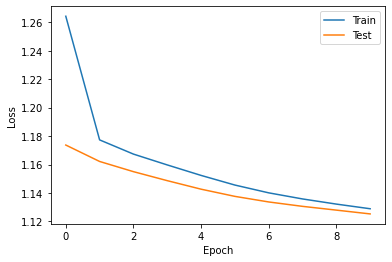

In [ ]:
plt.plot(train_losses, label = 'Train')
plt.plot(test_losses, label = 'Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#calibration 
def calibration(preds, actuals, groupsize = 10000, title = '', xlab = 'Predicted Rate', ylab = 'Actual Rate'):

    sorted_preds = preds[np.argsort(preds)]
    sorted_actuals = actuals[np.argsort(preds)]
    predicted = []
    actual = []
    numgroups = len(preds) // groupsize
    for i in range(numgroups):
        if i == numgroups-1:
            rows = [j for j in range(i*groupsize, len(preds))]
        else:
            rows = [j for j in range(i*groupsize, (i+1) * groupsize)]
        group_preds = sorted_preds[rows]
        group_actuals = sorted_actuals[rows]
        actual.append(np.mean(group_actuals))
        predicted.append(np.mean(group_preds))

    plt.plot(predicted, actual, 'k.')
    plt.plot(predicted, predicted, 'r-')
    plt.xlabel(xlab)
    plt.title(title)
    plt.ylabel(ylab)

In [ ]:
model = RNN(hidden_size = 32, output_size = 9).to(device)
model.load_state_dict(torch.load('/drive/My Drive/Colab Notebooks/sequencing_project/final_OP'))

<All keys matched successfully>

In [ ]:
predicted_test_data = pd.DataFrame()
for batch in range(len(test_loader_list)):
  ids, x, y = test_loader_list[batch]
  
  ypred = prediction_func(x,y)

  y = y.view(y.size(0)*y.size(1))
  losses = nn.CrossEntropyLoss(reduction = 'none')(ypred, y.cuda())
  new_data = pd.DataFrame({'pa_id': ids[:,0], 'pitch_number': ids[:,1], 'outcome': y.cpu().numpy()})
  new_data[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = nn.functional.softmax(ypred, dim = 1).detach().cpu().numpy()
  new_data['cross_entropy_loss'] = losses.detach().cpu().numpy()
  predicted_test_data = predicted_test_data.append(new_data, ignore_index = True)

In [ ]:
baseline_test_data = pd.DataFrame()
for batch2 in range(len(test_loader_list)):
  ids, x, y_truth = test_loader_list[batch2]
  x = x.to(device)
  y_truth = y_truth.to(device)
  h = bmodel.init_hidden().repeat(x.size(0)*x.size(1),1).to(device)
  preds = bmodel.input_embedding(x.view((x.size(0) * x.size(1), x.size(2))), h)

  y_truth = y_truth.view((y_truth.size(0)*y_truth.size(1)))
  losses = nn.CrossEntropyLoss(reduction = 'none')(preds, y_truth)
  new_data = pd.DataFrame({'pa_id': ids[:,0], 'pitch_number': ids[:,1], 'outcome': y_truth.cpu().numpy()})
  new_data[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = nn.functional.softmax(preds, dim = 1).detach().cpu().numpy()
  new_data['cross_entropy_loss'] = losses.detach().cpu().numpy()
  baseline_test_data = baseline_test_data.append(new_data, ignore_index = True)

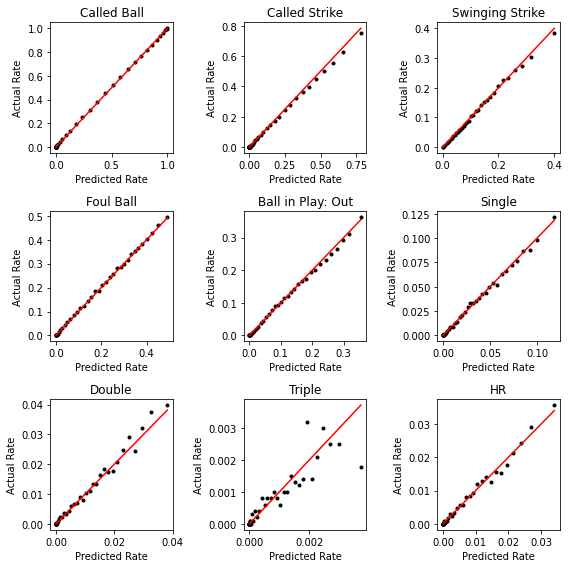

In [ ]:
#RNN calibration
fig= plt.figure(figsize=(8,8))
ax1 = plt.subplot(331)
ax1 = calibration(predicted_test_data.o0.values, (predicted_test_data.outcome.values == 0).astype(bool).astype(int), title = 'Called Ball')

ax2 = plt.subplot(332)
ax2 = calibration(predicted_test_data.o1.values, (predicted_test_data.outcome.values == 1).astype(bool).astype(int), title = 'Called Strike')

ax3 = plt.subplot(333)
ax3 = calibration(predicted_test_data.o2.values, (predicted_test_data.outcome.values == 2).astype(bool).astype(int), title = 'Swinging Strike')

ax4 = plt.subplot(334)
ax4 = calibration(predicted_test_data.o3.values, (predicted_test_data.outcome.values == 3).astype(bool).astype(int), title = 'Foul Ball')

ax5 = plt.subplot(335)
ax5 = calibration(predicted_test_data.o4.values, (predicted_test_data.outcome.values == 4).astype(bool).astype(int), title = 'Ball in Play: Out')

ax6 = plt.subplot(336)
ax6 = calibration(predicted_test_data.o5.values, (predicted_test_data.outcome.values == 5).astype(bool).astype(int), title = 'Single')

ax7 = plt.subplot(337)
ax7 = calibration(predicted_test_data.o6.values, (predicted_test_data.outcome.values == 6).astype(bool).astype(int), title = 'Double')

ax8 = plt.subplot(338)
ax8 = calibration(predicted_test_data.o7.values, (predicted_test_data.outcome.values == 7).astype(bool).astype(int), title = 'Triple')

ax9 = plt.subplot(339)
ax9 = calibration(predicted_test_data.o8.values, (predicted_test_data.outcome.values == 8).astype(bool).astype(int), title = 'HR')

plt.tight_layout()
plt.show()

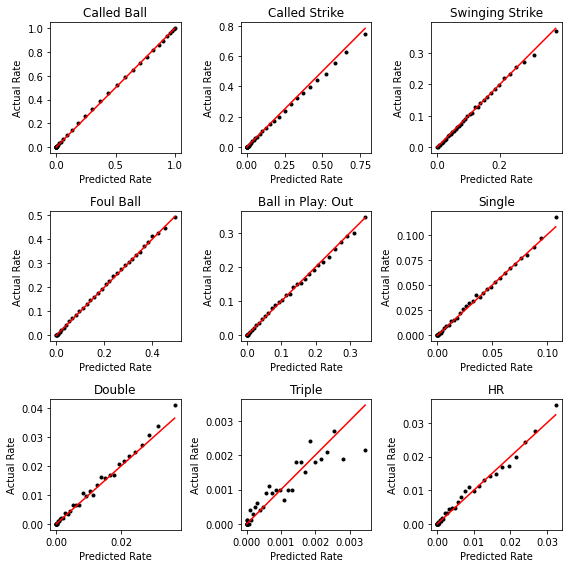

In [ ]:
#baseline calibration
fig= plt.figure(figsize=(8,8))
ax1 = plt.subplot(331)
ax1 = calibration(baseline_test_data.o0.values, (baseline_test_data.outcome.values == 0).astype(bool).astype(int), title = 'Called Ball')

ax2 = plt.subplot(332)
ax2 = calibration(baseline_test_data.o1.values, (baseline_test_data.outcome.values == 1).astype(bool).astype(int), title = 'Called Strike')

ax3 = plt.subplot(333)
ax3 = calibration(baseline_test_data.o2.values, (baseline_test_data.outcome.values == 2).astype(bool).astype(int), title = 'Swinging Strike')

ax4 = plt.subplot(334)
ax4 = calibration(baseline_test_data.o3.values, (baseline_test_data.outcome.values == 3).astype(bool).astype(int), title = 'Foul Ball')

ax5 = plt.subplot(335)
ax5 = calibration(baseline_test_data.o4.values, (baseline_test_data.outcome.values == 4).astype(bool).astype(int), title = 'Ball in Play: Out')

ax6 = plt.subplot(336)
ax6 = calibration(baseline_test_data.o5.values, (baseline_test_data.outcome.values == 5).astype(bool).astype(int), title = 'Single')

ax7 = plt.subplot(337)
ax7 = calibration(baseline_test_data.o6.values, (baseline_test_data.outcome.values == 6).astype(bool).astype(int), title = 'Double')

ax8 = plt.subplot(338)
ax8 = calibration(baseline_test_data.o7.values, (baseline_test_data.outcome.values == 7).astype(bool).astype(int), title = 'Triple')

ax9 = plt.subplot(339)
ax9 = calibration(baseline_test_data.o8.values, (baseline_test_data.outcome.values == 8).astype(bool).astype(int), title = 'HR')

plt.tight_layout()
plt.show()

In [ ]:
#where are the predictions most different?
baseline_test_data.columns = ['pa_id', 'pitch_number', 'outcome', 'bo0','bo1','bo2','bo3','bo4','bo5','bo6','bo7','bo8', 'b_loss']
test_data = predicted_test_data.merge(baseline_test_data, how = 'inner', on = ['pa_id', 'pitch_number'])
test_data['pred_diff'] = np.sqrt((test_data.o0.values - test_data.bo0.values)**2 + (test_data.o1.values - test_data.bo1.values)**2 + (test_data.o3.values - test_data.bo3.values)**2 + (test_data.o4.values - test_data.bo4.values)**2 + (test_data.o5.values - test_data.bo5.values)**2 + (test_data.o6.values - test_data.bo6.values)**2 + (test_data.o7.values - test_data.bo7.values)**2 + (test_data.o8.values - test_data.bo8.values)**2)

In [ ]:
diffs_by_pitch_num = test_data.groupby('pitch_number', as_index = False).agg(N = ('pred_diff', 'count'), diff = ('pred_diff', 'mean'),
                                                                             baseline_loss = ('b_loss', 'mean'), rnn_loss = ('cross_entropy_loss', 'mean'))
diffs_by_pitch_num['loss_diff'] = diffs_by_pitch_num.rnn_loss.values - diffs_by_pitch_num.baseline_loss.values
diffs_by_pitch_num

,pitch_number,N,diff,baseline_loss,rnn_loss,loss_diff
0,1,92562,0.029952,0.987635,0.990462,0.002827
1,2,81984,0.044014,1.124780,1.121091,-0.003689
2,3,69056,0.052592,1.140061,1.131409,-0.008652
3,4,53194,0.059791,1.131627,1.118868,-0.012759
4,5,36362,0.066177,1.239547,1.221667,-0.017880
5,6,19410,0.071157,1.295305,1.277546,-0.017758
6,7,8101,0.076884,1.291178,1.276426,-0.014752
7,8,3180,0.086075,1.362268,1.342796,-0.019472
8,9,980,0.094916,1.305257,1.271537,-0.033720
9,10,313,0.108257,1.359103,1.336553,-0.022549


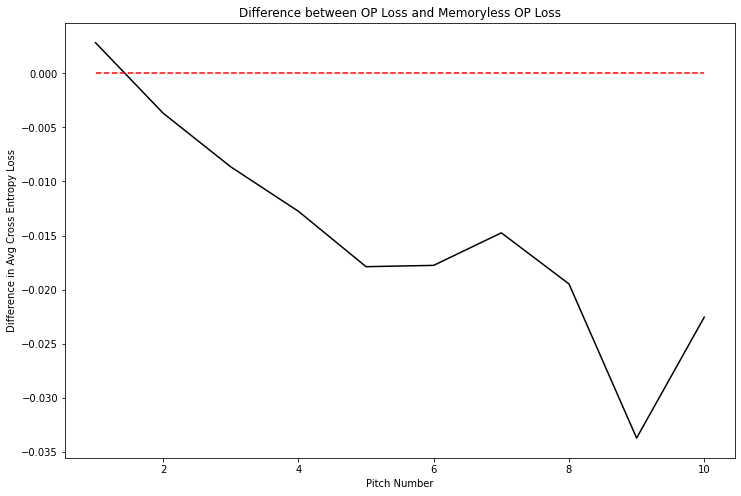

In [ ]:
#plot loss diffs, but only if we have more than 100 pitches in the sample
fig = plt.figure(figsize = (12,8))
qualified = diffs_by_pitch_num.loc[diffs_by_pitch_num.N >= 100]
plt.plot(qualified.pitch_number.values, qualified.loss_diff.values, 'k')
plt.plot([1,qualified.shape[0]],[0,0], 'r--')
plt.ylabel('Difference in Avg Cross Entropy Loss')
plt.xlabel('Pitch Number')
plt.title('Difference between OP Loss and Memoryless OP Loss')
plt.show()

In [ ]:
predicted_test_data.cross_entropy_loss.mean(), baseline_test_data.b_loss.mean()

(1.114018, 1.1209402)

The previous cell shows that the RNN has better overall cross entropy loss on the holdout set. Likewise, the previous plot shows that RNN loss gets even better relative to the non-RNN baseline as we get deeper into the sequence. 

**Testing on 2018-2020**

In [ ]:
model = RNN(hidden_size = 32, output_size = 9).to(device)
model.load_state_dict(torch.load('/drive/My Drive/Colab Notebooks/sequencing_project/final_OP'))

<All keys matched successfully>

In [ ]:
predicted_test_data = pd.DataFrame()
for batch in range(len(loader_list)):
  ids, x, y = loader_list[batch]
  
  ypred = prediction_func(x,y)

  y = y.view(y.size(0)*y.size(1))
  losses = nn.CrossEntropyLoss(reduction = 'none')(ypred, y.cuda())
  new_data = pd.DataFrame({'pa_id': ids[:,0], 'pitch_number': ids[:,1], 'outcome': y.cpu().numpy()})
  new_data[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = nn.functional.softmax(ypred, dim = 1).detach().cpu().numpy()
  new_data['cross_entropy_loss'] = losses.detach().cpu().numpy()
  predicted_test_data = predicted_test_data.append(new_data, ignore_index = True)

KeyboardInterrupt: ignored

In [ ]:
baseline_test_data = pd.DataFrame()
for batch2 in range(len(loader_list)):
  ids, x, y_truth = loader_list[batch2]
  x = x.to(device)
  y_truth = y_truth.to(device)
  h = bmodel.init_hidden().repeat(x.size(0)*x.size(1),1).to(device)
  preds = bmodel.input_embedding(x.view((x.size(0) * x.size(1), x.size(2))), h)

  y_truth = y_truth.view((y_truth.size(0)*y_truth.size(1)))
  losses = nn.CrossEntropyLoss(reduction = 'none')(preds, y_truth)
  new_data = pd.DataFrame({'pa_id': ids[:,0], 'pitch_number': ids[:,1], 'outcome': y_truth.cpu().numpy()})
  new_data[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = nn.functional.softmax(preds, dim = 1).detach().cpu().numpy()
  new_data['cross_entropy_loss'] = losses.detach().cpu().numpy()
  baseline_test_data = baseline_test_data.append(new_data, ignore_index = True)

In [ ]:
#RNN calibration
fig= plt.figure(figsize=(8,8))
ax1 = plt.subplot(331)
ax1 = calibration(predicted_test_data.o0.values, (predicted_test_data.outcome.values == 0).astype(bool).astype(int), title = 'Called Ball')

ax2 = plt.subplot(332)
ax2 = calibration(predicted_test_data.o1.values, (predicted_test_data.outcome.values == 1).astype(bool).astype(int), title = 'Called Strike')

ax3 = plt.subplot(333)
ax3 = calibration(predicted_test_data.o2.values, (predicted_test_data.outcome.values == 2).astype(bool).astype(int), title = 'Swinging Strike')

ax4 = plt.subplot(334)
ax4 = calibration(predicted_test_data.o3.values, (predicted_test_data.outcome.values == 3).astype(bool).astype(int), title = 'Foul Ball')

ax5 = plt.subplot(335)
ax5 = calibration(predicted_test_data.o4.values, (predicted_test_data.outcome.values == 4).astype(bool).astype(int), title = 'Ball in Play: Out')

ax6 = plt.subplot(336)
ax6 = calibration(predicted_test_data.o5.values, (predicted_test_data.outcome.values == 5).astype(bool).astype(int), title = 'Single')

ax7 = plt.subplot(337)
ax7 = calibration(predicted_test_data.o6.values, (predicted_test_data.outcome.values == 6).astype(bool).astype(int), title = 'Double')

ax8 = plt.subplot(338)
ax8 = calibration(predicted_test_data.o7.values, (predicted_test_data.outcome.values == 7).astype(bool).astype(int), title = 'Triple')

ax9 = plt.subplot(339)
ax9 = calibration(predicted_test_data.o8.values, (predicted_test_data.outcome.values == 8).astype(bool).astype(int), title = 'HR')

plt.tight_layout()
plt.show()

In [ ]:
#baseline calibration
fig= plt.figure(figsize=(8,8))
ax1 = plt.subplot(331)
ax1 = calibration(baseline_test_data.o0.values, (baseline_test_data.outcome.values == 0).astype(bool).astype(int), title = 'Called Ball')

ax2 = plt.subplot(332)
ax2 = calibration(baseline_test_data.o1.values, (baseline_test_data.outcome.values == 1).astype(bool).astype(int), title = 'Called Strike')

ax3 = plt.subplot(333)
ax3 = calibration(baseline_test_data.o2.values, (baseline_test_data.outcome.values == 2).astype(bool).astype(int), title = 'Swinging Strike')

ax4 = plt.subplot(334)
ax4 = calibration(baseline_test_data.o3.values, (baseline_test_data.outcome.values == 3).astype(bool).astype(int), title = 'Foul Ball')

ax5 = plt.subplot(335)
ax5 = calibration(baseline_test_data.o4.values, (baseline_test_data.outcome.values == 4).astype(bool).astype(int), title = 'Ball in Play: Out')

ax6 = plt.subplot(336)
ax6 = calibration(baseline_test_data.o5.values, (baseline_test_data.outcome.values == 5).astype(bool).astype(int), title = 'Single')

ax7 = plt.subplot(337)
ax7 = calibration(baseline_test_data.o6.values, (baseline_test_data.outcome.values == 6).astype(bool).astype(int), title = 'Double')

ax8 = plt.subplot(338)
ax8 = calibration(baseline_test_data.o7.values, (baseline_test_data.outcome.values == 7).astype(bool).astype(int), title = 'Triple')

ax9 = plt.subplot(339)
ax9 = calibration(baseline_test_data.o8.values, (baseline_test_data.outcome.values == 8).astype(bool).astype(int), title = 'HR')

plt.tight_layout()
plt.show()

In [ ]:
#where are the predictions most different?
baseline_test_data.columns = ['pa_id', 'pitch_number', 'outcome', 'bo0','bo1','bo2','bo3','bo4','bo5','bo6','bo7','bo8', 'b_loss']
test_data = predicted_test_data.merge(baseline_test_data, how = 'inner', on = ['pa_id', 'pitch_number'])
test_data['pred_diff'] = np.sqrt((test_data.o0.values - test_data.bo0.values)**2 + (test_data.o1.values - test_data.bo1.values)**2 + (test_data.o3.values - test_data.bo3.values)**2 + (test_data.o4.values - test_data.bo4.values)**2 + (test_data.o5.values - test_data.bo5.values)**2 + (test_data.o6.values - test_data.bo6.values)**2 + (test_data.o7.values - test_data.bo7.values)**2 + (test_data.o8.values - test_data.bo8.values)**2)

In [ ]:
diffs_by_pitch_num = test_data.groupby('pitch_number', as_index = False).agg(N = ('pred_diff', 'count'), diff = ('pred_diff', 'mean'),
                                                                             baseline_loss = ('b_loss', 'mean'), rnn_loss = ('cross_entropy_loss', 'mean'))
diffs_by_pitch_num['loss_diff'] = diffs_by_pitch_num.rnn_loss.values - diffs_by_pitch_num.baseline_loss.values
diffs_by_pitch_num

,pitch_number,N,diff,baseline_loss,rnn_loss,loss_diff
0,1,363612,0.029306,0.985504,0.986595,0.001091
1,2,321950,0.043322,1.141042,1.135320,-0.005722
2,3,266885,0.051504,1.166209,1.154509,-0.011699
3,4,201670,0.058197,1.162302,1.146299,-0.016004
4,5,133830,0.065794,1.255687,1.237438,-0.018249
5,6,72601,0.069999,1.314826,1.292646,-0.022180
6,7,29639,0.076848,1.322753,1.297726,-0.025027
7,8,11476,0.086106,1.340213,1.319834,-0.020379
8,9,4171,0.095726,1.363164,1.333918,-0.029247
9,10,1559,0.102307,1.362088,1.344618,-0.017470


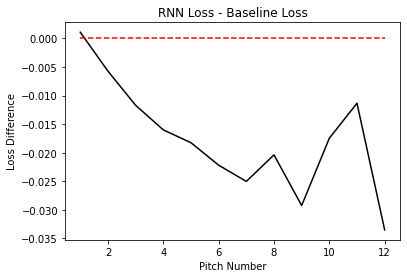

In [ ]:
#plot loss diffs, but only if we have more than 100 pitches in the sample
qualified = diffs_by_pitch_num.loc[diffs_by_pitch_num.N >= 100]
plt.plot(qualified.pitch_number.values, qualified.loss_diff.values, 'k')
plt.plot([1,qualified.shape[0]],[0,0], 'r--')
plt.ylabel('Loss Difference')
plt.xlabel('Pitch Number')
plt.title('RNN Loss - Baseline Loss')
plt.show()

In [ ]:
predicted_test_data.cross_entropy_loss.mean(), baseline_test_data.b_loss.mean()

(1.1258183, 1.1350338)

**Comparing Baseline and OP on Diaz/Moustakas at bat**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#define utility function 
count_runs = pd.DataFrame({'balls_pre_event': [3,3,2,3,2,1,0,1,2,0,1,0], 'strikes_pre_event': [0,1,0,2,1,0,0,1,2,1,2,2],
                           'val_ball': [0.131,0.201,0.110,0.276,0.103,0.063,0.034,0.050,0.098,0.027,0.046,0.022],
                           'val_strike': [-0.070,-0.076,-0.062,-0.351,-0.071,-0.050,-0.043,-0.067,-0.252,-0.062,-0.206,-0.184],
                           'val_out': [-0.496,-0.426,-0.385,-0.350,-0.323,-0.323, -0.289,-0.273,-0.252,-0.246,-0.206,-0.184],
                           'val_single': [0.287,0.356,0.397,0.432,0.459,0.460,0.494,0.510,0.530,0.537,0.577,0.598],
                           'val_double': [0.583,0.652,0.693,0.728,0.755,0.756,0.790,0.805,0.826,0.832,0.872,0.894],
                           'val_triple': [0.861,0.930,0.971,1.006,1.033,1.034,1.068,1.083,1.104,1.110,1.150,1.172],
                           'val_hr': [1.2,1.269,1.31,1.345,1.372,1.373,1.407,1.423,1.443,1.45,1.490,1.511]})

def get_utilities(pitch_df):
  '''
  pitch_df is a pandas dataframe with a column for balls, strikes, and the 
  probabilities of each outcome, named o1, o2, o3, o4, o5, o6, o7, and o8

  Returns the expected utility of a swing and of a take for that pitch.
  The batter's optimal utility for the pitch is the larger of those two values
  '''

  pitch_df['swing_utility'] = -1 
  pitch_df['take_utility'] = -1
  pitch_df['overall_utility'] = -1
  for balls in pitch_df.balls.unique():
    for strikes in pitch_df.strikes.unique():
      d = pitch_df.loc[(pitch_df.balls == balls) & (pitch_df.strikes == strikes)]

      #get the corresponding row from count_runs table
      count_pre = count_runs.loc[(count_runs.balls_pre_event == balls) & (count_runs.strikes_pre_event == strikes)]

      #get the value of a called ball 
      val0 = count_pre.val_ball.values[0]

      #get the value of a called or swinging strike 
      val12 = count_pre.val_strike.values[0]

      #value of a foul ball 
      if strikes == 2:
        #no change 
        val3 = 0 
      else:
        #value of foul is just value of a strike
        val3 = count_pre.val_strike.values[0] 

      #value of ball in play out 
      val4 = count_pre.val_out.values[0]
      #single 
      val5 = count_pre.val_single.values[0]
      #double 
      val6 = count_pre.val_double.values[0]
      #triple 
      val7 = count_pre.val_triple.values[0]
      #hr 
      val8 = count_pre.val_hr.values[0]

      #calculate utilities 
      no_swing = d.o0.values + d.o1.values 
      swing = d[['o2','o3','o4','o5','o6','o7','o8']].values.sum(axis = 1)
      take_utility = (d.o0.values / no_swing) * val0 + (d.o1.values/no_swing) * val12
      swing_utility = (d.o2.values/swing) * val12 + (d.o3.values/swing)*val3 + (d.o4.values/swing)*val4 + (d.o5.values/swing)*val5 + (d.o6.values/swing)*val6 + (d.o7.values/swing)*val7 + (d.o8.values/swing) * val8
      d.swing_utility = swing_utility 
      d.take_utility = take_utility  
      d.overall_utility = d.take_utility.values * no_swing + d.swing_utility.values*swing
      pitch_df.loc[(pitch_df.strikes == strikes) & (pitch_df.balls == balls), ['swing_utility', 'take_utility', 'overall_utility']] = d[['swing_utility', 'take_utility', 'overall_utility']].values

  return pitch_df       

In [ ]:
game = pybaseball.statcast(start_dt = '2022-07-06', end_dt = '2022-07-06')

This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:10<00:00, 10.76s/it]


In [ ]:
game = organize_data(game)

In [ ]:
pa = game.loc[(game.pitcher == 621242) & (game.batter == 519058)]

In [ ]:
pa['plate_x_ft'] = pa.plate_x.values 
pa['plate_z_ft'] = pa.plate_z.values
pa['velo'] = pa.release_speed.values
pa[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_extension', 'release_spin_rate', 
     'release_pos_x', 'release_pos_z']] = standardizer.transform(pa[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_extension', 'release_spin_rate', 
     'release_pos_x', 'release_pos_z']].values)

     

In [ ]:
pa = pa.merge(batter_indices, on = 'batter')

In [ ]:
pa = pa[::-1]

batch_x = pa[features].values.astype(float)
batch_y = pa.outcome.values.astype(int)
#reshape 
batch_x = batch_x.reshape((1, pa.shape[0], len(features)))
batch_y = batch_y.reshape((1,pa.shape[0]))
torch_batch_x = torch.tensor(batch_x, dtype = torch.float)
torch_batch_y = torch.tensor(batch_y, dtype = torch.long)

#test with OP
ypred = prediction_func(torch_batch_x, torch_batch_y)
losses = nn.CrossEntropyLoss(reduction = 'none')(ypred, torch_batch_y.squeeze(0).cuda())
pa[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = nn.functional.softmax(ypred, dim = 1).detach().cpu().numpy()
pa['cross_entropy_loss'] = losses.detach().cpu().numpy()
pa['swing_likelihood'] = 1-pa.o0.values-pa.o1.values
pa = get_utilities(pa)


In [ ]:
#test with baseline model 
x = torch_batch_x.to(device)
y_truth = torch_batch_y.to(device)
h = bmodel.init_hidden().repeat(x.size(0)*x.size(1),1).to(device)
preds = bmodel.input_embedding(x.view((x.size(0) * x.size(1), x.size(2))), h)

bpa = pa.copy()
y_truth = y_truth.view((y_truth.size(0)*y_truth.size(1)))
losses = nn.CrossEntropyLoss(reduction = 'none')(preds, y_truth)
bpa[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = nn.functional.softmax(preds, dim = 1).detach().cpu().numpy()
bpa['cross_entropy_loss'] = losses.detach().cpu().numpy()
bpa['swing_likelihood'] = 1-bpa.o0.values-bpa.o1.values
bpa = get_utilities(bpa)

In [ ]:
pa[['pitch_type', 'player_name', 'batter', 'balls', 'strikes', 'pitch_number', 'outcome', 'o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8', 'cross_entropy_loss', 'take_utility', 'swing_utility', 'overall_utility', 'swing_likelihood']]

,pitch_type,player_name,batter,balls,strikes,pitch_number,outcome,o0,o1,o2,o3,o4,o5,o6,o7,o8,cross_entropy_loss,take_utility,swing_utility,overall_utility,swing_likelihood
4,FF,"Díaz, Edwin",519058,0,0,1,2,0.357754,0.140973,0.265840,0.181065,0.038878,0.010751,2.869191e-03,2.126254e-04,1.656885e-03,1.324860,0.012235,-0.040530,-0.014215,0.501273
3,FF,"Díaz, Edwin",519058,0,1,2,2,0.004448,0.041819,0.289991,0.463711,0.142315,0.042473,8.596600e-03,6.261177e-04,6.020079e-03,1.237905,-0.053444,-0.044409,-0.044827,0.953734
2,FF,"Díaz, Edwin",519058,0,2,3,0,0.998195,0.000001,0.001352,0.000407,0.000035,0.000009,7.053651e-07,7.561128e-09,1.061002e-07,0.001807,0.022000,-0.138144,0.021711,0.001804
1,FF,"Díaz, Edwin",519058,1,2,4,0,0.885023,0.011815,0.024555,0.060343,0.013758,0.003466,7.594372e-04,2.809881e-05,2.526109e-04,0.122142,0.042680,-0.046736,0.033456,0.103162
0,SL,"Díaz, Edwin",519058,2,2,5,2,0.304350,0.158069,0.297010,0.173308,0.049564,0.012412,3.170521e-03,2.472955e-04,1.868602e-03,1.213988,-0.021641,-0.139831,-0.085177,0.537581


In [ ]:
bpa[['pitch_type', 'player_name', 'batter', 'balls', 'strikes', 'pitch_number', 'outcome', 'o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8', 'cross_entropy_loss', 'take_utility', 'swing_utility', 'overall_utility', 'swing_likelihood']]

,pitch_type,player_name,batter,balls,strikes,pitch_number,outcome,o0,o1,o2,o3,o4,o5,o6,o7,o8,cross_entropy_loss,take_utility,swing_utility,overall_utility,swing_likelihood
4,FF,"Díaz, Edwin",519058,0,0,1,2,0.359838,0.135497,0.275540,0.177005,0.037813,0.009595,0.002788,2.130532e-04,1.710502e-03,1.289022,0.012937,-0.041237,-0.014403,0.504664
3,FF,"Díaz, Edwin",519058,0,1,2,2,0.003928,0.024840,0.280466,0.477740,0.151625,0.043178,0.010418,6.588682e-04,7.145838e-03,1.271303,-0.049847,-0.042586,-0.042795,0.971232
2,FF,"Díaz, Edwin",519058,0,2,3,0,0.996721,0.000001,0.002002,0.001144,0.000105,0.000024,0.000002,3.194664e-08,4.035132e-07,0.003284,0.022000,-0.113295,0.021556,0.003278
1,FF,"Díaz, Edwin",519058,1,2,4,0,0.855272,0.007208,0.023013,0.083327,0.021928,0.007449,0.001232,8.325799e-05,4.890540e-04,0.156336,0.043894,-0.022262,0.034796,0.137521
0,SL,"Díaz, Edwin",519058,2,2,5,2,0.195355,0.126392,0.194028,0.307372,0.129357,0.032525,0.009346,8.009538e-04,4.824788e-03,1.639754,-0.039491,-0.071785,-0.061395,0.678253


In [ ]:
bpa[['pitch_number', 'pitch_type', 'velo', 'plate_x_ft', 'plate_z_ft']]

,pitch_number,pitch_type,velo,plate_x_ft,plate_z_ft
4,1,FF,98.6,-0.52,3.56
3,2,FF,99.5,-0.73,2.91
2,3,FF,100.0,0.98,4.64
1,4,FF,100.4,1.15,3.09
0,5,SL,91.6,-0.89,3.15


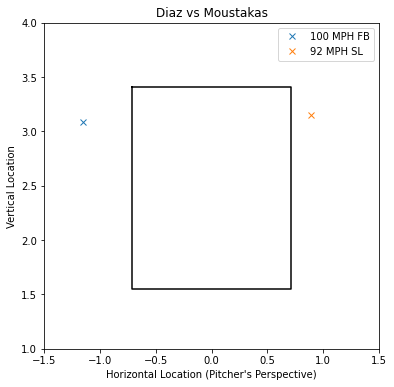

In [ ]:
#plot the locations of the last two pitches to visualize (hard in, soft away)
plt.figure(figsize=(6,6))
plt.plot([-1.15], [3.09], 'x', label = '100 MPH FB')
plt.plot([0.89], [3.15], 'x', label = '92 MPH SL')
plt.plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
plt.legend()
plt.xlim(-1.5,1.5)
plt.ylim(1,4)
plt.xlabel("Horizontal Location (Pitcher's Perspective)")
plt.ylabel("Vertical Location")
plt.title('Diaz vs Moustakas')
plt.show()